# Тестовое задание в команду продуктовой аналитики, Gett.

В папке с заданием два датасета - data_orders - содержит выборку данных по заказам пользователей и включает такие колонки как:

- order_datetime - время заказа
- origin_longitude - долгота
- origin_latitude - широта
- m_order_eta - время до прибытия машины
- order_gk - номер заказа
- order_status_key - статус (4 - отменен клиентом, 9 - отменен системой (reject))
- is_driver_assigned_key - был ли назначен водитель
- cancellations_time_in_seconds - сколько секунд прошло до отмены

data_offers - содержит пары номер заказа - ID оффера, который был предложен водителю по данному заказу.

В момент когда клиент нажимать на кнопку "Заказать" в приложении, система матчинга подыскивает наиболее релевантых водителей и предлагаем им заказ. В задании предлагается исследовать некоторые метрики матчинга для заказов, которые не завершились успешно (клиент в итоге не получил машину).

**0.** Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_orders = pd.read_csv('data_orders.csv')
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [3]:
df_orders['order_datetime'] = pd.to_datetime(df_orders['order_datetime'])   # изменение типа данных на datetime
df_orders['hour'] = df_orders['order_datetime'].dt.hour   # добавление графы с часом заказа
df_orders['order_datetime'] = df_orders['order_datetime'].dt.strftime('%H:%M:%S')   # задание формата
df_orders.head(3)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,hour
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,20
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12


In [4]:
df_orders.describe()

,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,hour
count,10716.000000,10716.000000,2814.000000,1.071600e+04,10716.000000,10716.000000,7307.000000,10716.000000
mean,-0.964323,51.450541,441.415423,3.000598e+12,5.590612,0.262598,157.892021,12.395110
std,0.022818,0.011984,288.006379,2.396261e+07,2.328845,0.440066,213.366963,7.660695
min,-1.066957,51.399323,60.000000,3.000550e+12,4.000000,0.000000,3.000000,0.000000
25%,-0.974363,51.444643,233.000000,3.000583e+12,4.000000,0.000000,45.000000,7.000000
50%,-0.966386,51.451972,368.500000,3.000595e+12,4.000000,0.000000,98.000000,13.000000
75%,-0.949605,51.456725,653.000000,3.000623e+12,9.000000,1.000000,187.500000,20.000000
max,-0.867088,51.496169,1559.000000,3.000633e+12,9.000000,1.000000,4303.000000,23.000000


Стооблец "m_order_eta" содержит значительное количество пропусков

In [5]:
df_orders['order_gk'][df_orders['cancellations_time_in_seconds'] > max(df_orders['m_order_eta'])].count()

16

*Имеются случаи, когда отмена заказов производилась после ожидания, кратно превышающего наибольшее в датафрейме значение ожидаемого времени прибытия машины*

In [6]:
df_offers = pd.read_csv('data_offers.csv')
df_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233017 entries, 0 to 233016
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   order_gk  233017 non-null  int64  
 1   offer_id  233016 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.6 MB


**1.** Постройте распределение заказов по причинам неуспеха: отмены до и после назначения водителя, режекты

In [11]:
df_reject_distr = df_orders.groupby(['order_status_key', 'is_driver_assigned_key'])['order_gk']\
.nunique().sort_values(ascending=False).reset_index()

def total_idx(row):
    if row['order_status_key'] == 4:
        idx_1 = 'отмена клиентом'
    else:
        idx_1 = 'отмена системой'
    if row['is_driver_assigned_key'] == 0:
        idx_2 = 'водитель не назначен'
    else:
        idx_2 = 'водитель назначен'
    return idx_1 + ' / ' + idx_2

df_reject_distr['total_idx'] = df_reject_distr.apply(total_idx, axis=1)
df_reject_distr

,order_status_key,is_driver_assigned_key,order_gk,total_idx
0,4,0,4496,отмена клиентом / водитель не назначен
1,9,0,3406,отмена системой / водитель не назначен
2,4,1,2811,отмена клиентом / водитель назначен
3,9,1,3,отмена системой / водитель назначен


Text(0.5, 1.0, 'Распределение отмененных заказов')

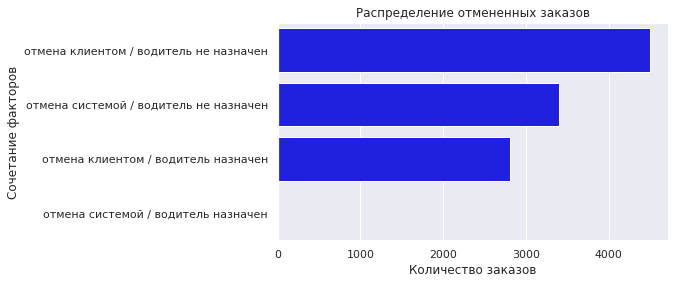

In [39]:
sns.set(style="darkgrid")
plt.figure(figsize=(7, 4))

ax = sns.barplot(
    x="order_gk", 
    y="total_idx", 
    data=df_reject_distr, 
    estimator=sum,
    color='blue')

plt.xlabel('Количество заказов')
plt.ylabel('Сочетание факторов')
plt.title('Распределение отмененных заказов')

Проанализируйте полученный график - в какой категории наибольшое количество заказов?

**Выводы:**
- большая часть заказов (~74%) была отменена клиентами самостоятельно либо отменены системой **до назначения водителя**
- 26% заказов была отменена **клиентами** самостоятельно при уже **назначенном водителе** *(вероятные причины - долгое ожидание, водитель не двигался на карте либо ехал в другую сторону / завершал другой заказ)*
- лишь 3 заказа были отменены системой при уже назначенном водителе

**2.** Постройте график распределения фейлов по часам - наблюдается ли тендеция, что в какие то часы доля той или иной категории аномально высока?

In [41]:
df_reject_hourly = df_orders.groupby(['hour'])['order_status_key'].value_counts().sort_values(ascending=False)
df_reject_hourly.head()

hour  order_status_key
8     4                   727
21    4                   550
23    4                   534
22    4                   475
0     4                   418
Name: order_status_key, dtype: int64

Text(0.5, 0, 'Час суток, инициатор отмены')

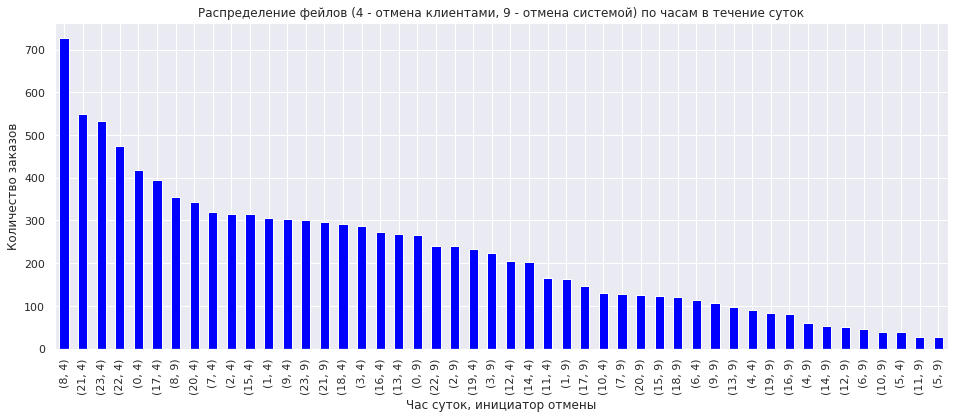

In [42]:
plt.figure(figsize = (16,6))
df_reject_hourly.plot(kind = 'bar', color='blue')
plt.title('Распределение фейлов (4 - отмена клиентами, 9 - отмена системой) по часам в течение суток')
plt.ylabel('Количество заказов')
plt.xlabel('Час суток, инициатор отмены')

Text(0, 0.5, 'Количество заказов')

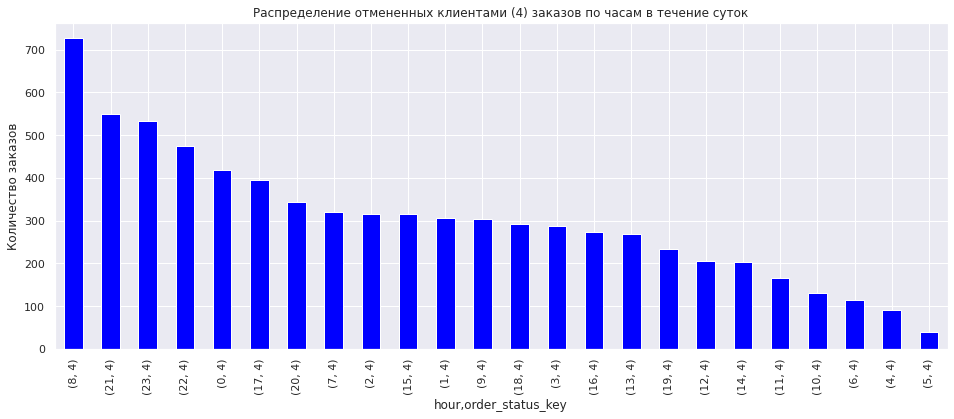

In [43]:
# отдельно по отмененным клиентами (статус 4):
df_reject_hourly_4 = df_orders[df_orders['order_status_key'] == 4].groupby(['hour'])['order_status_key'].value_counts().sort_values(ascending=False)

plt.figure(figsize = (16,6))
df_reject_hourly_4.plot(kind = 'bar', color='blue')
plt.title('Распределение отмененных клиентами (4) заказов по часам в течение суток')
plt.ylabel('Количество заказов')

Text(0, 0.5, 'Количество заказов')

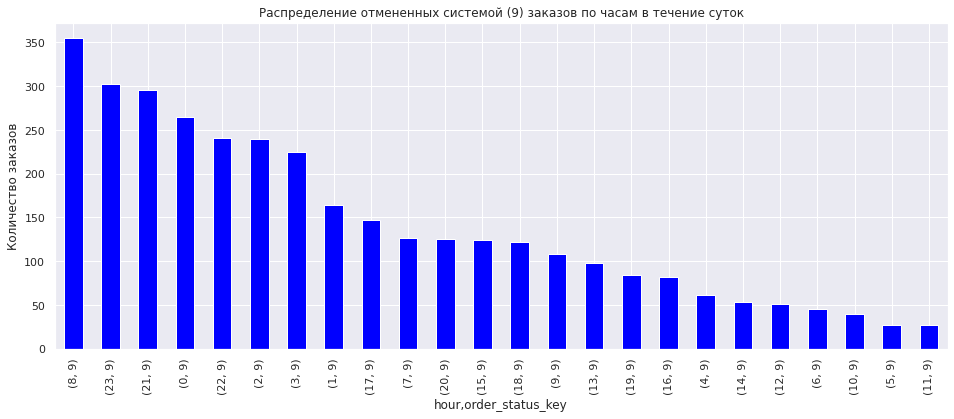

In [44]:
# отдельно по отмененным системой (статус 9):
df_reject_hourly_9 = df_orders[df_orders['order_status_key'] == 9].groupby(['hour'])['order_status_key'].value_counts().sort_values(ascending=False)

plt.figure(figsize = (16,6))
df_reject_hourly_9.plot(kind = 'bar', color='blue')
plt.title('Распределение отмененных системой (9) заказов по часам в течение суток')
plt.ylabel('Количество заказов')

In [45]:
# накопительная нормализованная диаграмма по типам отмененных заказов по часам суток - подготовка данных
df_reject_hourly_v2 = df_reject_hourly.rename('count')
df_reject_hourly_v2 = df_reject_hourly_v2.reset_index()
df_reject_hourly_4v2 = df_reject_hourly_v2[df_reject_hourly_v2['order_status_key'] == 4].sort_values(by='hour').set_index('hour')
df_reject_hourly_9v2 = df_reject_hourly_v2[df_reject_hourly_v2['order_status_key'] == 9].sort_values(by='hour').set_index('hour')
df_reject_hourly_4v2 = df_reject_hourly_4v2['count'].tolist()
df_reject_hourly_9v2 = df_reject_hourly_9v2['count'].tolist()

Text(0, 0.5, '% от общего количества отмененных заказов')

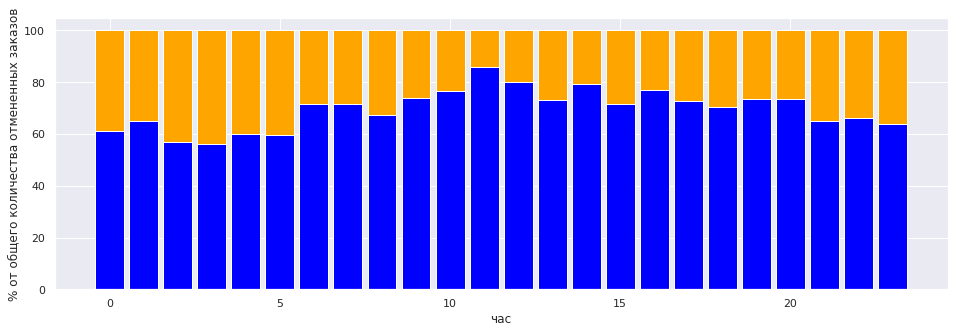

In [47]:
# построение диаграммы:

r = range(0,24)
raw_data = {'status_4': df_reject_hourly_4v2, 'status_9': df_reject_hourly_9v2}
df = pd.DataFrame(raw_data)

totals = [i+j for i,j in zip(df_reject_hourly_4v2, df_reject_hourly_9v2)]
bar1 = [i / j * 100 for i,j in zip(df_reject_hourly_4v2, totals)]
bar2 = [i / j * 100 for i,j in zip(df_reject_hourly_9v2, totals)]

plt.figure(figsize = (16,5))
barWidth = 0.85
plt.bar(r, bar1, color='blue', edgecolor='white', width=barWidth)
plt.bar(r, bar2, bottom=bar1, color='orange', edgecolor='white', width=barWidth)
plt.xlabel("час")
plt.ylabel("% от общего количества отмененных заказов")

# синий цвет - отменены клиентами, оранжевый - отменены системой

В какие часы фейлов больше всего? Чем это можно объяснить?

**Выводы:**

1) Наибольшее количество отмененных заказов приходится на 8 утра (причем как отмененных клиентами, так и системой). Это, вероятнее всего, связано с длительным временем ожидания и высокой ценой поездки в утренний час пик.

2) Чуть меньшее количество отмененных заказов по обеим категориям отмен фиксируется в интервале с 21 до 00 (24) часов. Предполагаемая причина - в выходные дни клиенты разъезжаются из гостей / ресторанов / с иных массовых мероприятий, и могут быть склонны к импульсивной отмене заказов (решили куда-то еще зайти, поехать на метро, взять каршгеринг и т.п.).

3) Наименьшее количество отмен заказов фиксируется в 5 часов утра, что может быть связано с малым количеством заказов в это время суток. Кроме того, клиенты, заказывающие такси в 5 утра, вероятнее всего куда-то спешат (аэропорт, вокзал, раннее совещания на работе и т.п.) и не имеют возможности отменить заказ.

4) Соотношение доли заказов, отмененных клиентами и системой, в течение суток значительно варьируется:
  - наибольшая доля отмененных системой заказов - в ночные часы (до 6 утра)
  - наибольшая доли отмененных клиентами заказов - в утренние, дневный и вечерние часы (максимум - в 11 утра)

Данный факт можно объяснить меньшим общим количеством заказов в ночное время, а также меньшим количеством водителей в ночное время, находящихся на смене.

**3.** Постройте графики среднего времени до отмены (cancellations_time_in_seconds) с водителем и без, по часам. Если есть выбросы в данных - лучше удалить. Можно ли сделать выводы по этому графику?

In [48]:
# проверка записей, в которых не было указано время отмены заказа:
df_orders.loc[df_orders['cancellations_time_in_seconds'].isna() == True].order_status_key.value_counts()

9    3409
Name: order_status_key, dtype: int64

*Все заказы с не указанным временем отмены соответствуют заказам, отмененным системой*

In [49]:
# Метрики (медиана и мода) без замены пропусков:
print(f"Медиана: {df_orders['cancellations_time_in_seconds'].median()}")
print(f"Мода: {df_orders['cancellations_time_in_seconds'].mode()[0]}")

Медиана: 98.0
Мода: 10.0


In [50]:
# Замена пропусков медианой исходя из времени суток (часа):
df_orders['cancellations_time_in_seconds'].fillna(df_orders.groupby('hour')['cancellations_time_in_seconds'].transform('median'), inplace=True)
df_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,hour
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,20
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,13
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,103.0,21


In [51]:
# Метрики (медиана и мода) после заполнения пропусков:
print(f"Медиана: {df_orders['cancellations_time_in_seconds'].median()}")
print(f"Мода: {df_orders['cancellations_time_in_seconds'].mode()[0]}")

Медиана: 99.0
Мода: 104.0


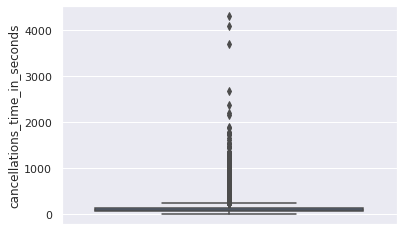

In [52]:
sns.boxplot(y=df_orders['cancellations_time_in_seconds'])

In [53]:
# удаление выбросов
q1  = df_orders['cancellations_time_in_seconds'].quantile(0.25)
q3  = df_orders['cancellations_time_in_seconds'].quantile(0.75)
iqr = q3 - q1  # межквартильный размах
lower_bound  = q1 - (1.5 * iqr) # нижняя граница диапазона
higher_bound = q3 + (1.5 * iqr) # верхняя граница диапазона

df_orders_cut = df_orders.loc[df_orders['cancellations_time_in_seconds'].between(lower_bound, higher_bound, inclusive = 'both')]

print('Метрики до удаления выбросов:')
print(f"Минимум: {df_orders['cancellations_time_in_seconds'].min()}")
print(f"Максимум: {df_orders['cancellations_time_in_seconds'].max()}")
print(f"Мода: {df_orders['cancellations_time_in_seconds'].mode()[0]}")
print(f"Медиана: {df_orders['cancellations_time_in_seconds'].median()}")
print(f"Стандартное отклонение: {df_orders['cancellations_time_in_seconds'].std()}\n")
print('Метрики после удаления выбросов:')
print(f"Минимум:    {df_orders_cut['cancellations_time_in_seconds'].min()}")
print(f"Максимум:    {df_orders_cut['cancellations_time_in_seconds'].max()}")
print(f"Мода:   {df_orders_cut['cancellations_time_in_seconds'].mode()[0]}")
print(f"Медиана: {df_orders_cut['cancellations_time_in_seconds'].median()}")
print(f"Стандартное отклонение: {df_orders_cut['cancellations_time_in_seconds'].std()}")

Метрики до удаления выбросов:
Минимум: 3.0
Максимум: 4303.0
Мода: 104.0
Медиана: 99.0
Стандартное отклонение: 178.39693198040501

Метрики после удаления выбросов:
Минимум:    3.0
Максимум:    247.0
Мода:   104.0
Медиана: 98.0
Стандартное отклонение: 54.0238228238659


In [54]:
df_driver_1 = df_orders_cut.loc[df_orders_cut['is_driver_assigned_key'] == 1].groupby('hour')['cancellations_time_in_seconds'].mean().reset_index().rename(columns={'cancellations_time_in_seconds': '1'}).sort_values(by='hour').set_index('hour')
df_driver_0 = df_orders_cut.loc[df_orders_cut['is_driver_assigned_key'] == 0].groupby('hour')['cancellations_time_in_seconds'].mean().reset_index().rename(columns={'cancellations_time_in_seconds': '0'}).sort_values(by='hour').set_index('hour')
df_united = pd.concat([df_driver_1, df_driver_0], axis=1).reset_index()

In [55]:
df_united = pd.melt(df_united, 'hour').rename(columns={'variable': 'driver'})
df_united.head()

,hour,driver,value
0,0,1,106.253333
1,1,1,99.216667
2,2,1,101.466667
3,3,1,75.615385
4,4,1,87.214286


Text(0, 0.5, 'среднее время отмены заказа, сек')

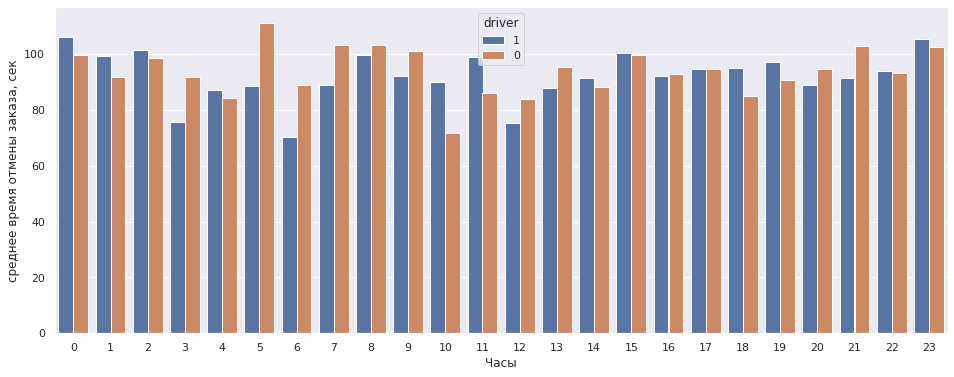

In [56]:
# построение почасовой диаграммы времени отмены заказов для 2 случаев - при назначенном водителе (1) и без него (0)
sns.set(style='darkgrid')    
plt.figure(figsize=(16, 6))
sns.barplot(x="hour", y="value", hue='driver', data=df_united, ci=None)
plt.xlabel("Часы")
plt.ylabel("среднее время отмены заказа, сек")

**Выводы:**

1) Среднее время отмены для заказов с назначенным и не назначенным водителем по часам в целом сопоставимо.

2) По отмененным заказам с назначенным водителем отмечаются значения ниже средних в 3-7 часов утра и 12-13 дня, что можно объяснить малым пассажиропотоком в указанные интервалы, что располагает к попыткам сделать новый заказ, если водитель медленно едет к месту вызова / двигается в другом направлении / завершает другой заказ / не отвечает на звонки и сообщения и т.п.

3) По отмененным заказам с не назначенными водителями фиксируются пики длительности в 5 утра, 7-9 утра, 23-02 часов ночи.

Вероятные причины:
- 5 утра - малое количество водителей на дежурстве (некому поблизости взять заказ)
- 7-9 утра - высокая загрузка водителей в утренние части пик
- 23-02 ночи - "импульсивные" отмены заказов либо мало водителей на дежурстве

**4.** Постройте распределение среднего ЕТА по часам. Чем можно объяснить такой вид графика?

In [57]:
# при подготовке данных было отмечено большое число пропусков в стобце "m_order_eta"
missed_eta_count = round(df_orders.m_order_eta.isna().mean()*100, 1)
print(f'Доля записей с незаполненными данными по ETA: {missed_eta_count}%')

Доля записей с незаполненными данными по ETA: 73.7%


*При таком преобладании пропусков их заполнение не будет корректным. От заполнения пропусков отказываемся.*

Text(0, 0.5, 'Среднее время до прибытия машины (сек.)')

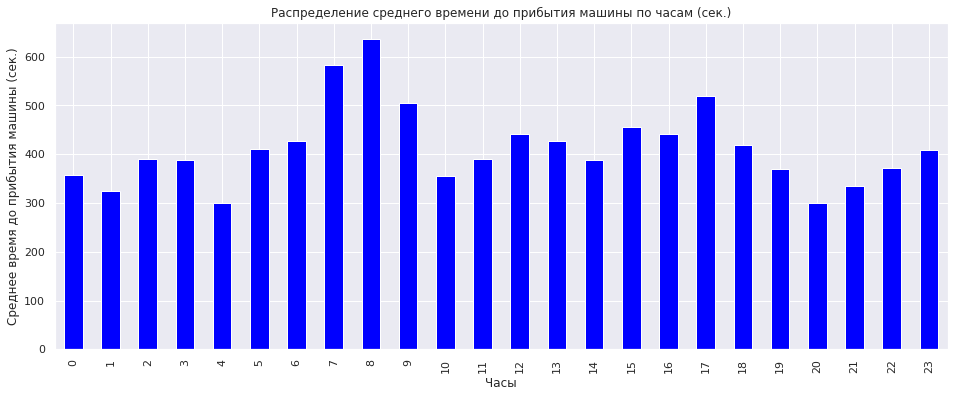

In [58]:
plt.figure(figsize = (16, 6))
df_orders.groupby('hour')['m_order_eta'].mean().plot(kind = 'bar', color='blue')
plt.title('Pаспределение среднего времени до прибытия машины по часам (сек.)')
plt.xlabel('Часы')
plt.ylabel('Среднее время до прибытия машины (сек.)')

**Выводы:**

1) Наибольшее ожидаемое время прибытия машины (ETA) - в утренние (07-08 ч.) часы пик, а также в вечерний час пик (17 ч.)

2) Наименьшие значения ETA - ночью (00-04 ч.) и поздним вечером (20-21 ч.)

3) Данный показатель, очевидно, коррелирует с количеством заказов и количеством водителей на дежурстве

4) Наибольшее значение ETA в 8 часов утра соответствует наибольшему количеству отменяемых заказов (см. диаграммы № 2-4 раздела 1)

5) Вероятно, существует взаимосвязь между ETA и долей заказов, отмененных клиентами (оценить в рамках работы невозможно в связи с отсутствием данных об успешно выполненных заказах)

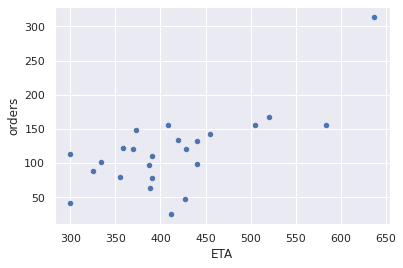

In [59]:
# проверка наличия взаимосвязи между ETA и количеством отмененных заказов:
df_eta_hourly = df_orders.groupby('hour')['m_order_eta'].mean()
df_orders_hourly = df_orders[df_orders['m_order_eta'].isna() != True].groupby('hour')['order_gk'].count()
df_corr = pd.concat([df_eta_hourly, df_orders_hourly], axis=1)
df_corr = df_corr.rename(columns={'m_order_eta': 'ETA', 'order_gk': 'orders'})
df_corr.plot(kind='scatter', x='ETA', y='orders')

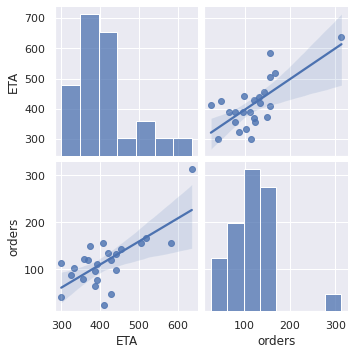

In [60]:
sns.pairplot(df_corr[['ETA', 'orders',]], kind='reg')


Визуально имеется заметная корреляция между ETA и количеством отмененных заказов

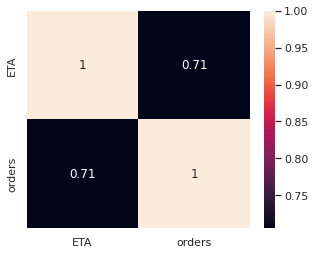

In [61]:
sns.set(rc={'figure.figsize':(5, 4)})
sns.heatmap(df_corr[['ETA', 'orders']].corr(), annot=True)

In [62]:
# коэффициент корреляции Пирсона
df_corr[['ETA', 'orders']].corr()

,ETA,orders
ETA,1.0000,0.7052
orders,0.7052,1.0000


In [63]:
# коэффициент корреляции Спирмена
df_corr[['ETA', 'orders']].corr(method='spearman')

,ETA,orders
ETA,1.000000,0.557998
orders,0.557998,1.000000


**Выводы:**

1) Оба метода расчета коэффициента корреляции показывают положительную корреляцию. В связи с наличием одного "выброса" корректнее использовать коэффициент корреляции Спирмена (0.56 - умеренно сильная положительная корреляция)

2) Однозначные выводы о взаимосвязи / зависимости сделать невозможно в связи с отсутствием в представленных датасетах данных об успешно выполненных заказах (оптимально было бы изучить взаимосвязь доли отмененных пользователями заказов (от общего количества заказов) и ETA)

**5.** Колонка drivers_offered - показывает сколько водителей увидели заказ и могли его принять. Постройте часовую разбивку среднего количества водителей которым был предложен заказ. Что можно сказать по ней про избыток/нехватку водителей в те или иные часы?

In [64]:
# требуется объединение двух исходных датафреймов
df_merged = df_orders.merge(df_offers, on = 'order_gk', how = 'left')

# расчет среднего количества водителей, которым были предложен заказ, в детализации по часам
df_of_drivers = df_merged.groupby(['order_gk', 'hour'])['offer_id'].nunique().reset_index()
df_of_drivers = df_of_drivers.rename(columns={'offer_id': 'drivers_count'})
df_of_hourly = df_of_drivers.groupby('hour').mean()
df_of_hourly

,order_gk,drivers_count
hour,,
0,3.000598e+12,2.016105
1,3.000597e+12,1.980892
2,3.000601e+12,1.819820
3,3.000597e+12,1.910331
4,3.000602e+12,1.039474
5,3.000594e+12,1.164179
6,3.000592e+12,1.597484
7,3.000599e+12,2.472036
8,3.000599e+12,2.470425


Text(0, 0.5, 'Среднее количество водителей, которым был предложен заказ')

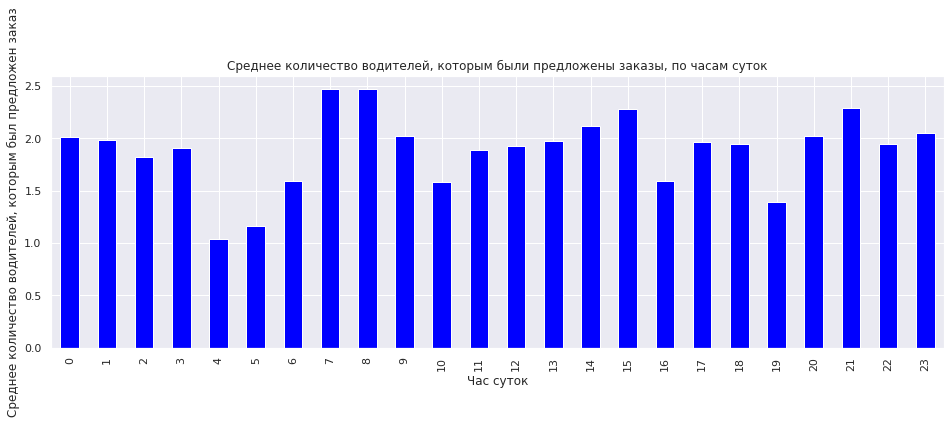

In [66]:
# построение диаграммы
plt.figure(figsize = (16, 5))
df_of_hourly['drivers_count'].plot(kind='bar', color='blue')
plt.title('Среднее количество водителей, которым были предложены заказы, по часам суток')
plt.xlabel('Час суток')
plt.ylabel('Среднее количество водителей, которым был предложен заказ')

**Выводы:**

1) В утренний час пик (7-8 утра), и в вечернее время (20-21 час), а также в 15 дня единичный заказ в среднем предлагался наибольшему числу водителей. В данное время, возможно, имеет место дефицит водителей из-за наплыва клиентов.

2) Наименьшее количество предложений на заказ поступало водителям в 4-5 часов утра (мало клиентов) и 19 часов вечера (наиболее дорогие поездки, часть клиентов предпочитает метро).

Text(0, 0.5, 'Количество заказов')

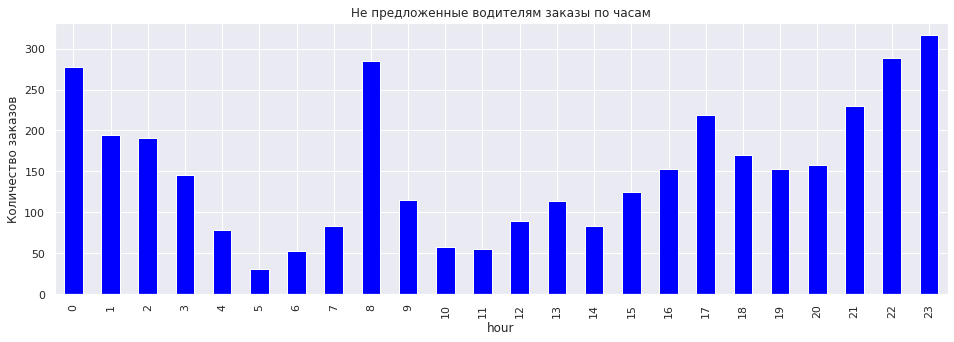

In [67]:
# анализ заказов, которые не были предложены ни одному водителю:
plt.figure(figsize = (16, 5))
plt.title('Не предложенные водителям заказы по часам')
df_of_drivers.loc[df_of_drivers['drivers_count'] == 0].groupby('hour')['drivers_count'].count().plot(kind='bar', color='blue')
plt.ylabel('Количество заказов')

**Выводы:**

1) Наибольшее количество заказов, которые не были предложены ни одному водителю, фиксируется в утренний час пик (8 ч., также соответствует периоду времени с максимальным количеством отмененных заказов) и поздний вечер (с 22 до 00 ч.).

2) Целесообразно рассмотреть возможность применения инструментов мотивации водителей для обеспечения необходимого количества водителей на дежурстве в указанные часы для снижения выявленной неэффективности распределения заказов.